This notebook builds on notebook 18. The purpose of it is to recalculate the times where the guest or the host are speaking.

In [1]:
import pandas as pd
import numpy as np

mer = pd.read_json("021_JV_segments_with_metadata.jsonl", orient="records", lines=True)
mer = mer[~mer.file.str.contains("_BzZf0fGg0E")]
corp = pd.read_json("020_JV_with_metadata.jsonl", orient="records", lines=True)

def lowercase_prune_whitespace(s:str) -> str:
    return " ".join(
        s.split()
    ).casefold()



In [40]:
from numpy import argmax
from fuzzywuzzy.fuzz import partial_ratio
i, row = list(mer.iterrows())[3]


def breakdown_speakers(row): #-> list[tuple(str, float, float)]
    SIMILARITY_LIMIT = 80
    file = row["file"]
    questions = corp.loc[corp.path == file, "host_questions"].tolist()[0]

    kaldi_text = row["kaldi_transcript"]
    speaker_breakdown = []
    is_tagged = "anchor_" in kaldi_text
    if not is_tagged:
        partial_ratios = [partial_ratio(j, kaldi_text) for j in questions]
        maximal_partial_ratio = max(partial_ratios)
        if maximal_partial_ratio >= SIMILARITY_LIMIT:
            speaker_breakdown.append((
                "host",
                min(row["kaldi_word_starts"]),
                max(row["kaldi_word_ends"])
            ))
        else:
            speaker_breakdown.append((
                "guest",
                min(row["kaldi_word_starts"]),
                max(row["kaldi_word_ends"])
            ))
    else:
        # We have 0 < tags < 6.
        words = row["kaldi_words"]
        starts = row["kaldi_word_starts"]
        ends = row["kaldi_word_ends"]
        assert len(words) == len(starts), "Kaldi Words and Starts are misshapen"
        assert len(words) == len(ends), "Kaldi Words and Ends are misshapen"

        segment_start = starts[0]
        is_host_start = [w.startswith("<anchor_start>") for w in words]
        is_host_end = [w.endswith("<anchor_end>") for w in words]
        speaking = None
        for start, end, is_start, is_end in zip(
            starts, ends, is_host_start, is_host_end):
            if not (is_start or is_end):
                continue
            if is_end:
                speaking = "guest"
                speaker_breakdown.append(( "host", segment_start, end))
                segment_start = end

            if is_start:
                speaking = "host"
                speaker_breakdown.append(("guest", segment_start, start))
                segment_start = start
        speaker_breakdown.append((speaking, segment_start, ends[-1]))

    return speaker_breakdown

breakdown_speakers(row)


[('guest', 62.98, 77.26), ('host', 77.26, 81.79)]

In [41]:
from tqdm.auto import tqdm
speaker_breakdowns = [breakdown_speakers(row) for i, row  in tqdm(mer.iterrows())]

0it [00:00, ?it/s]

In [42]:
mer["speaker_breakdown"] = speaker_breakdowns

In [44]:
mer.to_json("023_JV_segments_matched_speaker_id_added.jsonl", orient="records", lines=True)

In [56]:
c = mer.similarity_ratio > 75
sset = mer[c]
(sset.end - sset.start).sum()/3600


68.60344444444445

In [46]:
mer.columns

Index(['file', 'start', 'end', 'asr_transcription', 'kaldi_transcript',
       'guest_name', 'guest_description', 'host', 'kaldi_words',
       'kaldi_word_starts', 'kaldi_word_ends', 'segment_file',
       'average_distance', 'similarity_ratio', 'speaker_breakdown'],
      dtype='object')

In [50]:
(mer.end - mer.start).sum()/3600

71.15511111111111

<AxesSubplot:ylabel='Frequency'>

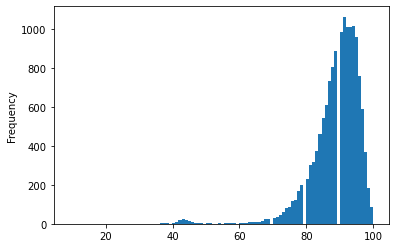

In [52]:
mer.similarity_ratio.plot.hist(bins=100)

# Converting the files to MP3:

In [16]:
from pydub import AudioSegment
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor

indir = Path("seg_audio")
outdir = Path("seg_audio_mp3")
try:
    outdir.mkdir()
except:
    pass
for inpath in indir.glob("*.wav"):
    print(inpath)
    break

def convert(inpath):
    audio = AudioSegment.from_wav(inpath)
    audio.export(str(outdir) + "/" + inpath.stem + ".mp3", format="mp3")

with ProcessPoolExecutor(max_workers=300) as executor:
    executor.map(convert, list(indir.glob("*.wav")))

seg_audio/a5xHn6JcDCs__141.8__158.2__.wav
